In [3]:
from diffeqpy import de
import numpy as np
import time
import tensorflow as tf

# **初始化**

In [4]:
import yaml

lb = 1e-8
n_epoch = 2500
n_plot = 10
grad_max = 1e2
maxiters = 50000

lr_max = 5e-3
lr_min = 1e-5
lr_decay = 0.2
lr_decay_step = 500
w_decay = 1e-8

llb = lb
p_cutoff = -1.0
R = -1.0 / 8.314e-3

l_exp = np.arange(1,15)
n_exp = len(l_exp)

l_train = []
l_val = []
for i in np.arange(0,n_exp):
    j = l_exp[i]
    if not (j in [2, 6, 9, 12]):
        l_train.append(i+1)
    else:
        l_val.append(i+1)


# **从文件读取实验数据**

In [5]:
# load data
import os


# load [t, T, m] data from files
def load_exp(filename):
    exp_data = np.loadtxt(filename)

    # 需要加一步去重
    # julia:
    # index = indexin(unique(exp_data[:, 1]), exp_data[:, 1])
    # exp_data = exp_data[index, :]

    exp_data[:, 2] = exp_data[:, 2] / max(exp_data[:, 2])
    return exp_data

l_exp_data = []
l_exp_info = np.zeros((len(l_exp), 3))

for i_exp, value in enumerate(l_exp):
    filename = "Biomass.jl-main\\exp_data\\expdata_no" + str(value) + ".txt"
    exp_data = np.float64(load_exp(filename))
    if value == 4:
        exp_data = exp_data[0:60, :]
    elif value == 5:
        exp_data = exp_data[0:58, :]
    elif value == 6:
        exp_data = exp_data[0:60, :]
    elif value == 7:
        exp_data = exp_data[0:71, :]

    l_exp_data.append(exp_data)
    l_exp_info[i_exp-1, 0] = exp_data[0,1] # get temperature

l_exp_info[:, 1] = np.loadtxt("Biomass.jl-main\\exp_data\\beta.txt")[l_exp-1]
l_exp_info[:, 2] = np.loadtxt("Biomass.jl-main\\exp_data\\ocen.txt")[l_exp-1] + llb

### 导入温度数据

In [87]:
def getsampletemp(t, T0, beta):
    
    if beta<100:
        T = T0 + beta / 60 * t
    else:
        tc = np.array([999.0, 1059.0]) * 60.0
        Tc = np.array([beta, 370.0, 500.0]) + 273.0
        HR = 40.0/60.0
        if t <= tc[0]:
            T = Tc[0]
        elif t <= tc[1]:
            T = min(Tc[0] + HR * (t-tc[0]), Tc[1])
        else:
            
            T = min(Tc[1] + HR * (t-tc[1]), Tc[2])
    return T

# **定义p矩阵的内容**

In [7]:
nr=8
ns=4

npara = nr * (ns + 4) + 1
p = np.random.rand(npara) * 1.e-2
p[0:nr] += 0.8  # w_b
p[nr*(ns+1):nr*(ns+2)] += 0.8  # w_out
p[nr*(ns+2):nr*(ns+4)] += 0.1  # w_b | w_Ea
p[-1] = 0.1  # slope
p_cutoff = -1

### P矩阵格式化及显示

In [88]:
def p2vec(p):
#p: numpy array
    p = np.array(p)
    slope = p[-1] *1e1

    # ln A
    w_b = p[:nr].copy() * (slope * 10.0)
    w_b = np.clip(w_b, 0, 50.0)
    # W_out
    w_out = np.reshape(p[nr:nr*(ns+1)].copy(), (nr, ns)).T
    np.clip(w_out[0,:], -3.0, 0.0, w_out[0,:])
    np.clip(np.abs(w_out[-1,:]), 0.0, 3.0, w_out[-1,:])

    if p_cutoff > 0:
        w_out[abs(w_out)<p_cutoff] = 0.0
    w_out[ns-2, :] = -1 * (np.sum(w_out[0:ns-1, :], axis=0) + w_out[-1,:])
    w_in_Ea = np.abs(p[nr*(ns+1):nr*(ns+2)]) * (slope * 100.0)
    np.clip(w_in_Ea, 0.0, 300.0, w_in_Ea)

    w_in_b = np.abs(p[nr*(ns+2):nr*(ns+3)])

    w_in_ocean = np.abs(p[nr*(ns+3):nr*(ns+4)])
    np.clip(w_in_ocean, 0.0, 1.5, w_in_ocean)

    if p_cutoff > 0:
        w_in_ocean[abs(w_in_ocean)<p_cutoff] = 0.0

    w_in = np.vstack((np.clip(w_out*(-1), 0.0, 4.0), w_in_Ea.T, w_in_b.T, w_in_ocean.T))
    return w_in, w_b, w_out

In [9]:
def display_p(p):
    w_in, w_b, w_out = p2vec(p)
    print("\n species (column) reaction (row)")
    print("w_in\t|Ea\t|b\t|n_ocen\t|lnA\t|w_out")
    np.set_printoptions(precision=2, suppress=True)
    print('{}'.format(np.hstack((w_in.T, w_b.reshape(8,1), w_out.T))))
    print("\n")
    

#display_p(p)

# **定义CRNN结构**

In [10]:
import julia
julia.install()

In [11]:
from julia import DiffEqSensitivity as ds

In [115]:
def crnn(u, p, t):
    logX = np.log(np.clip(u, lb, 10.0)).reshape(4,1)
    T = getsampletemp(t, T0, beta)
    T = np.array([T]).reshape((1,1))
    global ocen
    ocen = np.array([ocen]).reshape(1,1)
    #, R/T.shape, np.log(T).shape, ocen.shape
    w_in_x = (w_in.T).dot(np.vstack((logX, R/T, np.log(T), ocen)))
    du = (w_out.dot(np.exp(w_in_x.reshape(nr,1) + w_b.reshape(nr,1)))).reshape(ns,)
    return du
    
tspan = [0.0, 1.0]
u0 = np.zeros(ns)
u0[0] = 1.0


# Callback functions
# julia:
#  condition(u, t, integrator) = u[1] < lb * 10.0
# affect!(integrator) = terminate!(integrator)
# _cb = DiscreteCallback(condition, affect!)
def condition(u, t, integrator):
    return u[0] < lb*10.0

#_cb = 

# 算法与自动微分定义
alg = de.AutoTsit5(de.TRBDF2(autodiff=True))
sense = ds.ForwardSensitivity(autojacvec=True)

def pred_n_ode(p, i_exp, exp_data):
    
    #全局变量定义
    global T0
    global beta
    global ocen
    global w_in
    global w_b
    global w_out

    T0, beta, ocen = l_exp_info[i_exp-1, :]
    w_in, w_b, w_out = p2vec(p)
    w_in = np.array(w_in)
    w_b = np.array(w_b)
    w_out = np.array(w_out)

    ts = exp_data[:,0] # 传地址，exp_data更改时ts亦更改
    tspan = [ts[0], ts[-1]]
    
    prob = de.ODEProblem(crnn, u0, tspan, p, abstol = lb)
    
    sol = de.solve(
        prob,
        alg,
        tspan = tspan,
        p = p,
        saveat = ts,
        sensalg = sense,
        maxiters = maxiters,
        # callback = _cb,
    )

    if sol.retcode == "Success":
        pass
    else:
        print("solver failed beta: %.0f ocen: %.2f", beta, np.exp(ocen))
  
    if len(sol.t) > len(ts):
        # @show exp_data[:, 1]
        # @show sol.t
        return sol.t[0:len(ts)], sol.u[:, 0:len(ts)]
    else:
        return sol.t, sol.u

def loss_neuralnode(p, i_exp):
    exp_data = l_exp_data[i_exp-1]
    pred_t, pred_u = np.array(pred_n_ode(p, i_exp, exp_data))
    
    # 需要一个解决方案：
    # 将[array([_, _, _, _]) array([_, _, _, _]) array([_, _, _, _]) ...]的列表合并为矩阵
    # 目前方法简陋低效
    global ns
    pred = np.zeros((len(pred_u), ns))
    for i in range(len(pred_u)):
        pred[i, :] = pred_u[i]

    masslist = np.sum(np.clip(pred[0:-1,:], 0, np.Inf),axis=0).T
    gaslist = np.clip(pred[-1,:], 0, np.Inf)

    # MAE
    loss = np.linalg.norm(masslist - exp_data[0:len(masslist), 2], ord=1) / len(masslist)
    
    if ocen < 1000.0:
        loss += np.linalg.norm(gaslist - (1 - exp_data[0:len(gaslist), 2]), ord=1) / len(gaslist)
    
    return loss

timetest1 = time.time()
loss = loss_neuralnode(p, 10)
timetest2 = time.time()
print("execution time: " + str(timetest2 - timetest1))
print("loss:" + str(loss))

execution time: 10.467533826828003
loss:13.496884135071689


# **训练过程**

### 自动微分

In [117]:
epoches = np.arange(n_epoch)
loss_epoch = np.float64(np.zeros(n_exp))
grad_norm = np.float64(np.zeros(n_exp))
temp = np.arange(1, n_exp+1)
np.random.shuffle(temp)
for i_exp in temp:
    if i_exp in l_val:
        continue
    #p = tf.Variable(p, dtype=np.float64)
    #p = tf.constant(p)
    with tf.GradientTape() as Tape:
        Tape.watch(p)
        loss_para = tf.Variable([[loss_neuralnode(p, i_exp)]])
    grad = Tape.gradient(loss_para, p)
    print(grad)

None
None
None
None
None
None
None
None
None
None


**5月7日**

`tf.GradientTape`在计算我们的问题中的梯度返回为`None`。查阅资料发现，`tf.GradientTape`要求计算过程能表示为清晰的**计算图**。而我们的CRNN模型与损失函数都含有大量的矩阵拆分运算。目前暂不明白Julia中的自动微分是如何运算的。

**5月8日:**

1. 研读`Julia`的`ForwardDiff.jl`等相关库，试图搞清楚原理
2. 继续学习`tf.GradientTape`的原理，并找突破口

可能的解决方案：用`Tensorflow`兼容的格式重新设计CRNN与损失函数使其能使用AutoDiff.

**5月10日：**

Julia的核心问题是反复运行时需要重复加载。而Python/Jupyter Notebook解决方案以分块运行、不用整个重复运行的优点。目前发现Jupyter Notebook可以搭载Julia内核，故可以直接解决这个问题。另外，在Julia平台的原始代码上做二次开发也有助于为我们省略大量不必要的麻烦。幸而，最近的转译工作并没有白费，它帮助我们极其深入地了解了CRNN的内核。

**5月11日：**

与初师兄讨论方向：是继续python还是Julia？

讨论结果：
> 之前采取的方式就是Jupyter Notebook，并不解决效率问题。

> 尝试下：

> 1. 在Python使用Julia内嵌语句解决梯度计算问题。

> 2. 继续探索TensorFlow重写模型的可能性。


# **CRNN结构测试**
p.txt为从Julia模型中训练好的矩阵，采用此矩阵来求解，验证正确性。

In [18]:
p_test = np.loadtxt("Biomass.jl-main\p.txt")

w_in_test, w_b_test, w_out_test = p2vec(p_test)


In [79]:
exp_data_test = l_exp_data[0]
T0_test, beta_test, ocen_test = l_exp_info[0, :]
print(ocen_test)
R = -1.0 / 8.314e-3

1e-08


In [108]:
ts_test = exp_data_test[:,0] # 传地址，exp_data更改时ts亦更改
tspan_test = np.array([ts_test[0], ts_test[-1]])

def getsampletemp(t, T0, beta):
    
    if beta<100:
        T = T0 + beta / 60 * t
    else:
        tc = np.array([999.0, 1059.0]) * 60.0
        Tc = np.array([beta, 370.0, 500.0]) + 273.0
        HR = 40.0/60.0
        if t <= tc[0]:
            T = Tc[0]
        elif t <= tc[1]:
            T = min(Tc[0] + HR * (t-tc[0]), Tc[1])
        else:
            
            T = min(Tc[1] + HR * (t-tc[1]), Tc[2])
    return T
def crnn_test(u, p, t):
    w_in_test, w_b_test, w_out_test = p2vec(p)
    logX = np.log(np.clip(u, lb, 10.0)).reshape(4,1)
    T_test = getsampletemp(t, T0_test, beta_test)
    T_test = np.array([T_test]).reshape(1,1)
    global ocen_test
    ocen_test = np.array([ocen_test]).reshape(1,1)
    w_in_x_test = np.dot(np.transpose(w_in_test), np.vstack((logX, R/T_test, np.log(T_test), ocen_test)))
    return np.dot(w_out_test, np.exp(w_in_x_test.reshape(8,1) + w_b_test.reshape(8,1))).reshape(4,)
    

u0 = np.zeros(ns)
u0[0] = 1.0


prob_test = de.ODEProblem(crnn_test, u0, tspan, p_test)

sol_test = de.solve(
    prob_test,
    alg = de.AutoTsit5(de.TRBDF2(autodiff=True)),
    #alg = de.AutoTsit5(de.Rosenbrock23()),
    #alg = de.Rodas4(),
    tspan = tspan_test,
    p = p_test,
    abstol = lb,
    saveat = ts_test,
    sensalg = ds.ForwardSensitivity(autojacvec = True),
    maxiters = maxiters,
    # callback = _cb,
)

In [109]:
print(crnn_test(u0, p_test, 100))

[-3.09236302e-05  6.77835156e-07  1.63449260e-05  1.41086479e-05]


In [110]:
pred_test = np.zeros((len(sol_test.u), ns))
for i in range(len(sol_test.u)):
    pred_test[i, :] = sol_test.u[i]
pred_t = sol_test.t

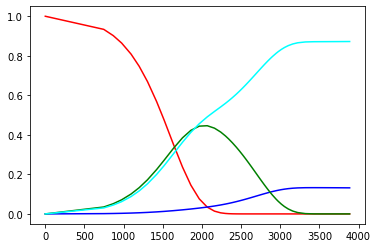

In [111]:
import matplotlib.pyplot as plt

plt.plot(pred_t, pred_test[:,0], c="r")
plt.plot(pred_t, pred_test[:,1], c="b")
plt.plot(pred_t, pred_test[:,2], c="g")
plt.plot(pred_t, pred_test[:,3], c="cyan")

plt.savefig("test.png",dpi=800)

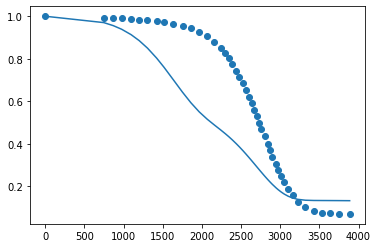

In [114]:
exp_masslist = exp_data_test[:, 2]
pred_masslist = np.sum(pred_test[:, :3], axis=1)
plt.scatter(pred_t, exp_masslist)
plt.plot(pred_t, pred_masslist)

In [118]:
pred_masslist

array([1.        , 0.97011731, 0.95581778, 0.93876029, 0.91334768,
       0.88525706, 0.84987892, 0.80305058, 0.75968519, 0.70105175,
       0.64255832, 0.59296631, 0.54976827, 0.51527293, 0.48775776,
       0.46492665, 0.44646915, 0.4332528 , 0.41765686, 0.39933753,
       0.38487703, 0.36841031, 0.35241634, 0.33590559, 0.32113562,
       0.30616101, 0.29108763, 0.27847761, 0.26567341, 0.24863343,
       0.23135775, 0.21819139, 0.20872039, 0.19152918, 0.18338783,
       0.17228719, 0.16273235, 0.15298996, 0.14437193, 0.13840606,
       0.13415574, 0.13296133, 0.13270981, 0.13252459, 0.13230086,
       0.13193485])